In [1]:
import torch
import torch.distributions as dist
import neml2
from pyzag import nonlinear, reparametrization, chunktime
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import os

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA is available")
    print(f"CUDA version: {torch.version.cuda}")
else:
    dev = "cpu"
    print("CUDA is not available")
device = torch.device(dev)

CUDA is available
CUDA version: 12.8


For 600_data:
Strain:
tensor([0.0000, 0.0006, 0.0017, 0.0028, 0.0028, 0.0044, 0.0061, 0.0105, 0.0215,
        0.0398, 0.0591, 0.0829, 0.0994, 0.1149, 0.1370, 0.1608, 0.1785, 0.1950,
        0.2138, 0.2331, 0.2492, 0.2685, 0.2895, 0.3110, 0.3315, 0.3492],
       device='cuda:0')
Stress:
tensor([  0.0000,  63.5659, 113.1783, 187.5969, 257.3643, 313.1783, 355.0388,
        384.4961, 392.2481, 393.7984, 392.2481, 390.6977, 386.0465, 386.0465,
        381.3953, 382.9457, 381.3953, 379.8450, 376.7442, 376.7442, 373.6434,
        373.6434, 365.8915, 353.4884, 347.2868, 328.6822], device='cuda:0')
For 500_data:
Strain:
tensor([0.0000, 0.0011, 0.0022, 0.0033, 0.0039, 0.0050, 0.0061, 0.0072, 0.0083,
        0.0122, 0.0122, 0.0188, 0.0249, 0.0403, 0.0575, 0.0751, 0.1006, 0.1210,
        0.1492, 0.1746, 0.1901], device='cuda:0')
Stress:
tensor([  0.0000,  88.2012, 170.2128, 244.4874, 303.2882, 365.1838, 439.4584,
        468.8588, 502.9014, 530.7544, 530.7544, 558.6074, 577.1760, 594.1973,
       

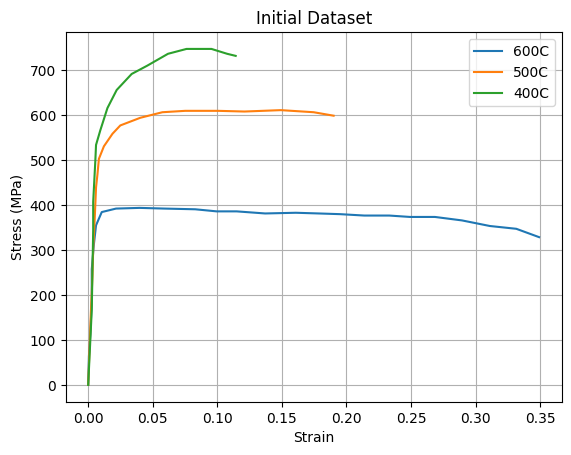

In [3]:
# Load experimental data
path = '/home/colinmoose/neml2/cmg_projects/tensile_data/var_temp'
data_frames = {}
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path)
        if '400' in filename:
            temp_label = '400'
        elif '500' in filename:
            temp_label = '500'
        elif '600' in filename:
            temp_label = '600'
        else:
            temp_label = 'unknown'
        
        new_df = df.rename(columns={'x':f'{temp_label}_strain', 'y':f'{temp_label}_stress'})
        data_frames[temp_label] = new_df

strain_data = {}
stress_data = {}

for temp_label, df in data_frames.items():
    strain_col = f'{temp_label}_strain'
    stress_col = f'{temp_label}_stress'
    strain = torch.tensor(df[strain_col].values, device=device)
    stress = torch.tensor(df[stress_col].values, device=device)
    max_stress_idx = torch.argmax(stress).item()
    # strain = strain[:max_stress_idx + 1]
    # stress = stress[:max_stress_idx + 1]
    strain = strain[:] - strain[0]
    stress = stress[:] - stress[0]
    strain_data[temp_label] = strain
    stress_data[temp_label] = stress
    print(f"For {temp_label}_data:\nStrain:\n{strain_data[temp_label]}\nStress:\n{stress_data[temp_label]}")

# Plot initial dataset
plt.figure()
for temp_label in strain_data:
    plt.plot(strain_data[temp_label].cpu().numpy(), stress_data[temp_label].cpu().numpy(), label=f"{temp_label}C")
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Initial Dataset')
plt.grid()
plt.legend()
plt.show()

In [4]:
nrate = 1
ntemperature = 3
nbatch = nrate * ntemperature
max_strain = 0.4
ntime = 100
rates = torch.tensor([1e-4], device=device)
temperatures = torch.linspace(400.0, 600.0, ntemperature, device=device)
print(f"--- Initial Experimental Conditions ---\nstrain rates:\n{rates}\ntemperatures:\n{temperatures}")

--- Initial Experimental Conditions ---
strain rates:
tensor([0.0001], device='cuda:0')
temperatures:
tensor([400., 500., 600.], device='cuda:0')


In [5]:
time = torch.zeros((ntime, nrate, ntemperature, 1), device=device)
loading = torch.zeros((ntime, nrate, ntemperature, 6), device=device)
temperature = torch.zeros((ntime, nrate, ntemperature, 1), device=device)
for i, rate in enumerate(rates):
    time[:, i] = torch.linspace(0, max_strain / rate, ntime, device=device)[:, None, None]
loading[..., 0] = torch.linspace(0, max_strain, ntime, device = device)[:, None, None]
for i, T in enumerate(temperatures):
    temperature[:, :, i] = T
time = time.reshape((ntime, -1, 1))
temperature = temperature.reshape((ntime, -1, 1))
loading = loading.reshape((ntime, -1, 6))

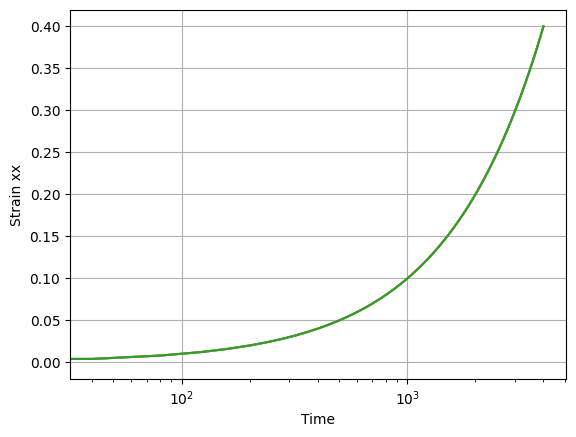

In [6]:
plt.semilogx(time[...,0].cpu(), loading[..., 0].cpu())
plt.xlabel("Time")
plt.ylabel("Strain xx")
plt.grid()

In [7]:
nmodel = neml2.load_model("test_model2.i", "implicit_rate")
nmodel.to(device = device)
print(nmodel)

Name:       implicit_rate
Input:      forces/T [Scalar]
            forces/control [SR2]
            forces/fixed_values [SR2]
            forces/t [Scalar]
            old_forces/control [SR2]
            old_forces/fixed_values [SR2]
            old_forces/t [Scalar]
            old_state/internal/ep [Scalar]
            old_state/mixed_state [SR2]
            state/internal/ep [Scalar]
            state/mixed_state [SR2]
Output:     residual/internal/ep [Scalar]
            resiudal/mixed_state [SR2]
Parameters: R_X [Scalar][Double][cuda:0]
            R_Y [Scalar][Double][cuda:0]
            d_X [Scalar][Double][cuda:0]
            d_Y [Scalar][Double][cuda:0]
            elasticity_E [Scalar][Double][cuda:0]
            elasticity_nu [Scalar][Double][cuda:0]
            flow_rate_eta [Scalar][Double][cuda:0]
            flow_rate_n [Scalar][Double][cuda:0]
            yield_sy [Scalar][Double][cuda:0]
Buffers:    Eerate_c_0 [Scalar][Double][cuda:0]
            Eerate_c_1 [Scalar][

In [8]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """

    def __init__(self, discrete_equations, nchunk=1, rtol=1.0e-6, atol=1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            temperature (torch.tensor): batched temperatures
            loading (torch.tensor): loading conditions, which are the input strain in the first base index and then the stress (zero) in the remainder
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations,
            step_generator=nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(),
            nonlinear_solver=chunktime.ChunkNewtonRaphson(rtol=self.rtol, atol=self.atol),
        )
        
        control = torch.zeros_like(loading)
        control[...,1:] = 1.0

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable(
            {
                "forces/t": time,
                "forces/control": loading,
                "forces/T": temperature
            }
        ).torch()
        state0 = torch.zeros(
            forces.shape[1:-1] + (self.discrete_equations.nstate,), device=forces.device
        )

        result = nonlinear.solve_adjoint(solver, state0, len(forces), forces)

        return result[...,0:1]

In [9]:
model = SolveStrain(neml2.pyzag.NEML2PyzagModel(nmodel, exclude_parameters = ["elasticity_E", "elasticity_nu"]))

ValueError: Wrapped NEML2 model should have ['residual'] as (the only) output subaxes. Got ['residual', 'resiudal']

In [ ]:
stress = model(time, temperature, loading)

In [ ]:
plt.plot(strain[..., 0].detach().cpu(), stress[...,0].detach().cpu())
plt.xlabel("Strain xx")
plt.ylabel("Stress xx")